## 1. Install libraries needed 

In [51]:
# Importing necessary libraries
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation
import random  # for shuffling the data
import nltk
import re  # for handling regular expressions

from nltk.stem import WordNetLemmatizer  # for lemmatizing words
from nltk.corpus import stopwords  # for stop word removal
from nltk.tokenize import word_tokenize  # for tokenizing sentences into words
nltk.download('punkt_tab')  # Downloads the 'punkt' tokenizer table used for tokenization of text into sentences or words
from nltk import bigrams  # For generating bigrams

# Downloading necessary NLTK resources
nltk.download('stopwords')  # List of common stop words in English
nltk.download('punkt')  # Pre-trained tokenizer models
nltk.download('wordnet')  # WordNet lemmatizer dataset

# Libraries for text feature extraction and model training
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text into numerical features (TF-IDF)
from sklearn.linear_model import LogisticRegression  # Logistic regression for classification
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.svm import LinearSVC  # Support Vector Machines for classification

# Libraries for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # For model evaluation metrics
from sklearn.model_selection import KFold, cross_val_score  # For cross-validation
from sklearn.model_selection import train_test_split # For splitting the dataset into training and testing sets
from sklearn.metrics import classification_report, accuracy_score  # For evaluating the model's performance

from collections import Counter  # For counting word frequencies

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dianaterraza/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dianaterraza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dianaterraza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dianaterraza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load and Prepare the Dataset

In [52]:
df = pd.read_csv('/Users/dianaterraza/Desktop/nlp_project/data/Restaurant_Reviews.tsv', sep='\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [53]:
print(df.iloc[100]['Review'])  # Display the review at index 100

Our server was fantastic and when he found out the wife loves roasted garlic and bone marrow, he added extra to our meal and another marrow to go!


In [54]:
df.iloc[122]['Liked']  # Display the sentiment label for the review at index 120

np.int64(1)

Liked – A binary target variable:
* 1: The customer liked the food.
* 0: The customer did not like the food.

### Count how many of every category we have

In [55]:
df['Liked'].value_counts()

Liked
1    500
0    500
Name: count, dtype: int64

### Look for null values 

In [56]:
df.isna().sum()

Review    0
Liked     0
dtype: int64

### Visualize the positive and negatives numbers: (1) Liked the food, (0) didnt liked the food

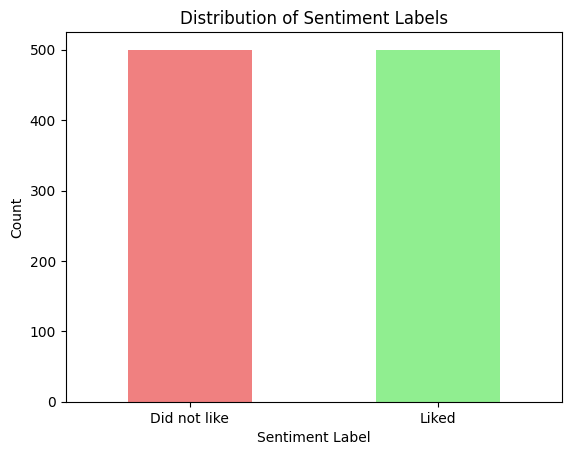

In [57]:
import matplotlib.pyplot as plt  # For plotting

#Get the values count 
counts = df['Liked'].value_counts()

#Create a bar plot
ax = counts.plot(kind='bar', color=['lightcoral', 'lightgreen'])
ax.set_title('Distribution of Sentiment Labels')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Did not like', 'Liked'], rotation=0)
plt.show()

To find frequent Keywords in Positive vs. Negative Reviews: Do certain words signal dissatisfaction (e.g., "cold," "slow," "expensive") while others indicate satisfaction (e.g., "delicious," "friendly," "cozy")?

For that I need first of all 
1. Do a text preprocessing 
2. Separate Text by Sentiment Category
3. Count Word Frequencies
4. Beyond Simple Frequency - Using N-grams

## 3.1 Text Preprocessing  

In [58]:
# Preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer() # Reducing words to their base or root form
    stop_words = set(stopwords.words('english')) #Eliminating common words like "the," "is," and "a" that don't carry much sentiment
    text = text.lower() #Converting all words to lowercase to ensure consistency
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    tokens = word_tokenize(text) # : Splitting the text into individual words or "tokens."
    filtered_tokens = [
        lemmatizer.lemmatize(token) for token in tokens
        if token not in stop_words
    ]
    return filtered_tokens

# Apply the preprocessing
df['clean_tokens'] = df['Review'].apply(preprocess_text)
print(df[['Review', 'clean_tokens']])

                                                Review  \
0                             Wow... Loved this place.   
1                                   Crust is not good.   
2            Not tasty and the texture was just nasty.   
3    Stopped by during the late May bank holiday of...   
4    The selection on the menu was great and so wer...   
..                                                 ...   
995  I think food should have flavor and texture an...   
996                           Appetite instantly gone.   
997  Overall I was not impressed and would not go b...   
998  The whole experience was underwhelming, and I ...   
999  Then, as if I hadn't wasted enough of my life ...   

                                          clean_tokens  
0                                  [wow, loved, place]  
1                                        [crust, good]  
2                              [tasty, texture, nasty]  
3    [stopped, late, may, bank, holiday, rick, stev...  
4                 

### 3.2 Separate Text by Sentiment Category

To find frequent words for each sentiment, I first need to group your data by its sentiment label in this case the Like column 

In [59]:
# Separate the DataFrame into positive and negative sentiments
positive_df = df[df['Liked'] == 1]
negative_df = df[df['Liked'] == 0]

# Flatten the list of tokens for each sentiment
positive_words = [token for tokens in positive_df['clean_tokens'] for token in tokens]
negative_words = [token for tokens in negative_df['clean_tokens'] for token in tokens]

### 3.3 Count Word Frequencies

Using collections.Counter to find the most common words for each category.



In [60]:
# Count the frequency of words in each sentiment group
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Get the top N most frequent words for each sentiment
top_10_positive = positive_word_counts.most_common(10)
top_10_negative = negative_word_counts.most_common(10)

print("\nTop 10 Positive Words:")
print(top_10_positive)
print("\nTop 10 Negative Words:")
print(top_10_negative)


Top 10 Positive Words:
[('good', 73), ('great', 70), ('place', 60), ('food', 60), ('service', 46), ('time', 26), ('friendly', 23), ('delicious', 23), ('back', 23), ('nice', 22)]

Top 10 Negative Words:
[('food', 65), ('place', 51), ('back', 38), ('service', 38), ('like', 29), ('time', 29), ('go', 26), ('dont', 25), ('good', 22), ('never', 22)]


### 3.4 Beyond Simple Frequency - Using N-grams

Simple word frequency (unigrams) can be misleading, especially with negations. For example, "not good" should be treated as a negative phrase, but a simple unigram count would count "good" as a positive word.

Using N-grams (sequences of N words) helps solve this. You can find frequent pairs of words (bigrams) or triples (trigrams) that might be more indicative of sentiment

In [61]:
# Generate bigrams for each sentiment
positive_bigrams = list(bigrams(positive_words))
negative_bigrams = list(bigrams(negative_words))

# Count the frequency of bigrams
positive_bigram_counts = Counter(positive_bigrams)
negative_bigram_counts = Counter(negative_bigrams)

# Get the top 10 most frequent bigrams for each sentiment
top_10_positive_bigrams = positive_bigram_counts.most_common(10)
top_10_negative_bigrams = negative_bigram_counts.most_common(10)

print("\nTop 10 Positive Bigrams:")
print(top_10_positive_bigrams)
print("\nTop 10 Negative Bigrams:")
print(top_10_negative_bigrams)


Top 10 Positive Bigrams:
[(('great', 'food'), 8), (('food', 'good'), 7), (('great', 'service'), 6), (('go', 'back'), 6), (('really', 'good'), 6), (('good', 'food'), 6), (('food', 'great'), 6), (('great', 'place'), 6), (('food', 'delicious'), 5), (('first', 'time'), 5)]

Top 10 Negative Bigrams:
[(('go', 'back'), 12), (('going', 'back'), 7), (('dont', 'think'), 5), (('wont', 'back'), 5), (('ever', 'go'), 5), (('anytime', 'soon'), 5), (('bad', 'food'), 4), (('never', 'ever'), 4), (('waste', 'time'), 4), (('zero', 'star'), 4)]


In [62]:
df.head()

,Review,Liked,clean_tokens
0,Wow... Loved this place.,1,"[wow, loved, place]"
1,Crust is not good.,0,"[crust, good]"
2,Not tasty and the texture was just nasty.,0,"[tasty, texture, nasty]"
3,Stopped by during the late May bank holiday of...,1,"[stopped, late, may, bank, holiday, rick, stev..."
4,The selection on the menu was great and so wer...,1,"[selection, menu, great, price]"


## 4. Shuffle the Data and Split in train and Test 

The main reason is to ensure that my training and test data sets are representative of the full data set.

Randomly shuffling the data ensures that the proportion of positive and negative reviews is roughly the same in both sets (training and testing), allowing the model to learn from all types of data and evaluate itself fairly.

In [63]:
# 1. Import the necessary library
from sklearn.model_selection import train_test_split

# 2. Prepare your data
# 'X' will be your features (the text or tokens column)
# 'y' will be your target variable (the 'Liked' sentiment column)
X = df['clean_tokens'].apply(lambda tokens: ' '.join(tokens))
y = df['Liked']

# 3. Split the data into training and testing sets.
# `train_test_split` automatically shuffles the data for you,
# so you don't need a separate shuffling step.
# `test_size` specifies the proportion for the test set (e.g., 20%)
# `random_state` ensures the split is the same every time you run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the size of the new datasets
print("Training set size (X_train):", X_train.shape)
print("Test set size (X_test):", X_test.shape)
print("Training target size (y_train):", y_train.shape)
print("Test target size (y_test):", y_test.shape)

Training set size (X_train): (800,)
Test set size (X_test): (200,)
Training target size (y_train): (800,)
Test target size (y_test): (200,)


## 5. Feature Engineering

Using techniques like TF-IDF, word embeddings, or sentiment lexicons to improve model performance.

TF-IDF stands for Term Frequency-Inverse Document Frequency 

The TF-IDF Vectorizer is a widely used tool for this purpose. It transforms sentences into a sparse matrix where each row corresponds to a document (sentence) and each column represents a term (word or token).

Here, we’ll use the TfidfVectorizer out of the box with its default configuration. By default, this includes:
* Only unigrams (individual terms/tokens) as features.
* A maximum document frequency of 1.0 (no terms are excluded based on frequency).
* Normalization applied to the resulting feature vectors.

In [64]:
# Import TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the vectorizer
# I add the parameter `ngram_range=(1, 2)` to include both unigrams (single words) and bigrams (two-word combinations).
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit the vectorizer on the TRAINING data and transform it.
# This learns the vocabulary and feature weights from the training set.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the TEST data using the SAME vectorizer.
# We use only `transform` here to apply the vocabulary and weights learned from the training data.
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shapes to confirm the transformation was successful
print("Shape of TF-IDF matrix (Training):", X_train_tfidf.shape)
print("Shape of TF-IDF matrix (Testing):", X_test_tfidf.shape)

Shape of TF-IDF matrix (Training): (800, 5020)
Shape of TF-IDF matrix (Testing): (200, 5020)


## 6. Training The Classifier: Model Selection 

### Comparative table between logistic regression vs. decision tree classifier

Logistic Regression is a linear model. It finds a straight line (or hyperplane) to separate the data. It's often a great baseline model, is fast to train, and its results are easy to interpret.

Decision Tree is a non-linear model. It makes a series of if-then-else decisions to classify data. It can capture more complex relationships but is prone to overfitting, meaning it might perform well on your training data but poorly on unseen test data. The max_depth parameter helps control this by limiting the complexity of the tree.

In [65]:
# Model 1: Logistic Regression
print("\n--- Training Logistic Regression Model ---")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions and evaluate
lr_predictions = lr_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))

# Model 2: Decision Tree
print("\n--- Training Decision Tree Model ---")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_tfidf, y_train)

# Make predictions and evaluate
dt_predictions = dt_model.predict(X_test_tfidf)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, dt_predictions))


--- Training Logistic Regression Model ---
Logistic Regression Accuracy: 0.79

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        96
           1       0.82      0.76      0.79       104

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200


--- Training Decision Tree Model ---
Decision Tree Accuracy: 0.645

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.93      0.71        96
           1       0.85      0.38      0.53       104

    accuracy                           0.65       200
   macro avg       0.72      0.66      0.62       200
weighted avg       0.72      0.65      0.62       200



### How to Interpret the Results: 

![Screenshot 2025-08-04 at 12.48.28.png](<attachment:Screenshot 2025-08-04 at 12.48.28.png>)
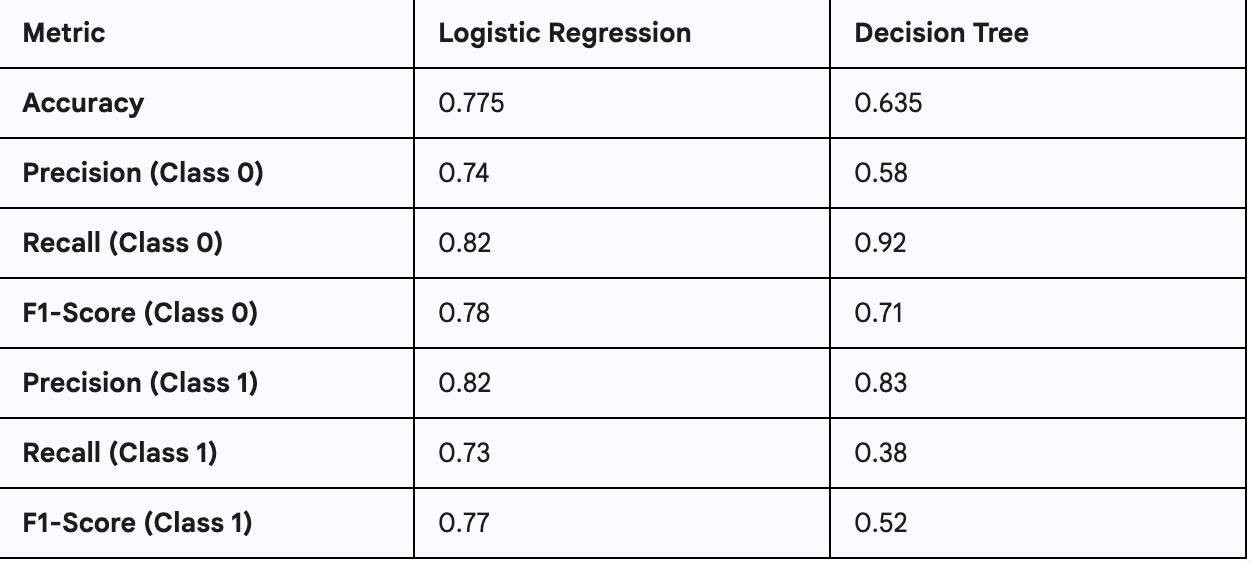

**Conclusion:** The Logistic Regression is the model with the best overall performance for this dataset, showing higher accuracy and a better balance between the metrics of both classes.

After selecting a model like Logistic Regression, the next professional step is to improve its performance and get a more reliable evaluation. 

The best way to do this is by combining two techniques:

* k-fold cross-validation: This involves splitting the data into multiple folds and training the model on different combinations of these folds. It gives a more stable and trustworthy performance score than a single train-test split.

* Hyperparameter tuning: This is the process of finding the optimal settings (hyperparameters) for your model, such as the C value in Logistic Regression, to maximize its performance.

The most effective and professional practice is to use a tool like GridSearchCV that performs both of these steps automatically, ensuring you find the best possible model settings and a reliable performance score.

## 7. Hyperparameter Tuning with Cross-Validation

In [49]:
# Import necessary libraries for cross-validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- Hyperparameter Tuning for Logistic Regression ---
# Cross-validation is used to find the best 'C' parameter
# (regularization strength) for the model.

print("\n--- Hyperparameter Tuning for Logistic Regression ---")

# Define the parameters you want to test.
# 'C' is the regularization hyperparameter. Smaller values mean
# stronger regularization.
param_grid = {'C': [0.1, 1.0, 10.0, 100.0]}

# Create the GridSearchCV object.
# - estimator: the model to be tuned (LogisticRegression).
# - param_grid: the dictionary of parameters to test.
# - cv: the number of folds for cross-validation.
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to your training data.
# This trains the model 5 times for each 'C' value.
grid_search.fit(X_train_tfidf, y_train)

# Display the best parameters found
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# --- Evaluation of the Best Model ---
# Use the best model found to make predictions on the test set
best_lr_model = grid_search.best_estimator_
best_lr_predictions = best_lr_model.predict(X_test_tfidf)

# Display the classification report of the best model
print("\n--- Evaluation of the Best Logistic Regression Model ---")
print("Accuracy of the best model: {:.3f}".format(accuracy_score(y_test, best_lr_predictions)))
print("\nClassification Report:\n", classification_report(y_test, best_lr_predictions))


--- Hyperparameter Tuning for Logistic Regression ---
Best parameters found:  {'C': 10.0}
Best cross-validation score: 0.79

--- Evaluation of the Best Logistic Regression Model ---
Accuracy of the best model: 0.795

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79        96
           1       0.82      0.77      0.80       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.80       200



**LinearSVC** is a fast and efficient linear classifier based on Support Vector Machines (SVM). 

It is particularly well-suited for high-dimensional datasets like those created from text data using TF-IDF. 
It finds an optimal boundary to separate classes and, like Logistic Regression, uses a C parameter to manage overfitting. 
By tuning and comparing it against your Logistic Regression model, you can determine which one is the best linear classifier for your specific sentiment analysis task.

In [50]:
# --- Hyperparameter Tuning for LinearSVC ---
# Similar to Logistic Regression, we'll tune the 'C' parameter for LinearSVC
print("\n--- Hyperparameter Tuning for LinearSVC ---")

# Define the parameters to test for LinearSVC.
param_grid_svc = {'C': [0.1, 1.0, 10.0, 100.0]}

# Create the GridSearchCV object for LinearSVC
grid_search_svc = GridSearchCV(LinearSVC(random_state=42), param_grid_svc, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search_svc.fit(X_train_tfidf, y_train)

# Display the best parameters and score
print("Best parameters found (LinearSVC): ", grid_search_svc.best_params_)
print("Best cross-validation score (LinearSVC): {:.2f}".format(grid_search_svc.best_score_))

# --- Evaluation of the Best LinearSVC Model ---
best_svc_model = grid_search_svc.best_estimator_
best_svc_predictions = best_svc_model.predict(X_test_tfidf)

print("\n--- Evaluation of the Best LinearSVC Model ---")
print("Accuracy of the best model: {:.3f}".format(accuracy_score(y_test, best_svc_predictions)))
print("\nClassification Report:\n", classification_report(y_test, best_svc_predictions))



--- Hyperparameter Tuning for LinearSVC ---
Best parameters found (LinearSVC):  {'C': 1.0}
Best cross-validation score (LinearSVC): 0.79

--- Evaluation of the Best LinearSVC Model ---
Accuracy of the best model: 0.795

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        96
           1       0.82      0.78      0.80       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.80       200



/Users/dianaterraza/Desktop/nlp_project/cat/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dianaterraza/Desktop/nlp_project/cat/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dianaterraza/Desktop/nlp_project/cat/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dianaterraza/Desktop/nlp_project/cat/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dianaterraza/Desktop/nlp_project/cat/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

### 8. Conclusion

Both the Logistic Regression and LinearSVC models, after being optimized with GridSearchCV, show nearly identical performance on your dataset.

Both models achieved a final accuracy of 0.795.

The F1-Score, Precision, and Recall metrics are also extremely close for both models.

In this case, either model would be an excellent choice. Since they perform similarly, the choice often comes down to other factors like training time or ease of implementation, but for this problem, the difference is negligible.

You can select either the hyperparameter-tuned Logistic Regression model or the LinearSVC model for your final sentiment classifier.